In [75]:
# Import python modules
import pandas as pd
import numpy as np
import sqlite3
import pprint
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
from scipy.stats import poisson 
from typing import List, Dict
from wordcloud import WordCloud

In [76]:
#settings
%matplotlib inline
sns.set_theme(style="whitegrid")
sns.set()
warnings.filterwarnings('ignore')

In [77]:
#create connection
con = sqlite3.connect("mental_health.sqlite")

In [78]:
#read the question
questions_df = pd.read_sql_query("SELECT * FROM question", con)

We can see that the last question has id 118, while it's index is 104, thus we have 105 questions. We can see that questions with ids 35-47 are missing. Let's pull a test df to make sure we didn't have them in the first place and we didn't lose them in the process

In [79]:
test =  pd.read_sql_query('SELECT * FROM Question WHERE QuestionID BETWEEN 35 AND 47 ', con)
test

,questiontext,questionid


Indeed we don't have any values with those IDs Let's examine countries participants are corrently living in

In [80]:
#read answers
answers_df = pd.read_sql_query("SELECT * FROM answer", con)
answers_df.columns = ['AnswerText', 'SurveyID',	'UserID', 'questionid']

In [81]:
#read survey
surveys_df = pd.read_sql_query("SELECT * FROM survey", con)

In [82]:
qa = pd.merge(answers_df, questions_df, how='left', on='questionid')
display(qa)
# qa
qa[qa['questiontext']=='What is your age?']

,AnswerText,SurveyID,UserID,questionid,questiontext
0,37,2014,1,1,What is your age?
1,44,2014,2,1,What is your age?
2,32,2014,3,1,What is your age?
3,31,2014,4,1,What is your age?
4,31,2014,5,1,What is your age?
...,...,...,...,...,...
236893,Other,2016,2689,117,Which of the following best describes your wor...
236894,Support,2016,2690,117,Which of the following best describes your wor...
236895,Back-end Developer,2016,2691,117,Which of the following best describes your wor...
236896,DevOps/SysAdmin,2016,2692,117,Which of the following best describes your wor...


,AnswerText,SurveyID,UserID,questionid,questiontext
0,37,2014,1,1,What is your age?
1,44,2014,2,1,What is your age?
2,32,2014,3,1,What is your age?
3,31,2014,4,1,What is your age?
4,31,2014,5,1,What is your age?
...,...,...,...,...,...
203936,27,2019,4214,1,What is your age?
203937,48,2019,4215,1,What is your age?
203938,50,2019,4216,1,What is your age?
203939,30,2019,4217,1,What is your age?


In [83]:
#join question and it's answer
df = pd.read_sql_query("SELECT * FROM question JOIN answer ON question.questionid = answer.QuestionID", con)
df.head()

,questiontext,questionid,AnswerText,SurveyID,UserID,QuestionID
0,What is your age?,1,-1,2014,391,1
1,What is your age?,1,-1,2014,716,1
2,What is your age?,1,-1,2014,1128,1
3,What is your age?,1,-1,2017,3447,1
4,What is your age?,1,-1,2017,3449,1


In [84]:
data = pd.read_sql_query(
                        'SELECT * FROM Question JOIN Answer \
                        ON Answer.QuestionID = Question.questionid \
                        JOIN Survey ON Answer.SurveyID = Survey.SurveyID'
                       ,con)
data.head()

,questiontext,questionid,AnswerText,SurveyID,UserID,QuestionID,SurveyID,Description
0,What is your age?,1,37,2014,1,1,2014,mental health survey for 2014
1,What is your age?,1,44,2014,2,1,2014,mental health survey for 2014
2,What is your age?,1,32,2014,3,1,2014,mental health survey for 2014
3,What is your age?,1,31,2014,4,1,2014,mental health survey for 2014
4,What is your age?,1,31,2014,5,1,2014,mental health survey for 2014


In [85]:
#data cleaning
del data['QuestionID']

In [86]:
#number of people join the survery by year
num_survey= """
select distinct SurveyID as Year, count(distinct UserID) as Num_users, count(UserID) as num_answer
from Answer
group by SurveyID"""
num_survey= pd.read_sql(sql=num_survey, con=con)
num_survey

,Year,Num_users,num_answer
0,2014,1260,32760
1,2016,1433,88238
2,2017,756,57456
3,2018,417,31692
4,2019,352,26752


In [87]:
# num_survey['response_percent'] = (num_survey['num_answer'] / num_survey['num_answer'].sum()) * 100
# num_survey['people_percent'] = (num_survey['Num_users'] / num_survey['Num_users'].sum()) * 100

In [88]:
# f, ax = plt.subplots(figsize=(8, 8))
# sb.set_color_codes("pastel")
# sb.barplot(x=num_survey['Year'], y= num_survey['response_percent'],label="Count of Response", color="b")
# sb.set_color_codes("muted")
# sb.barplot(x=num_survey['Year'], y= num_survey['people_percent'],label="Count of Response", color="b")
# ax.legend(ncol=2, loc="upper left", frameon=True)
# ax.set(ylabel="", xlabel="Number of Students enrolled")
# sb.despine(left=True, bottom=True)

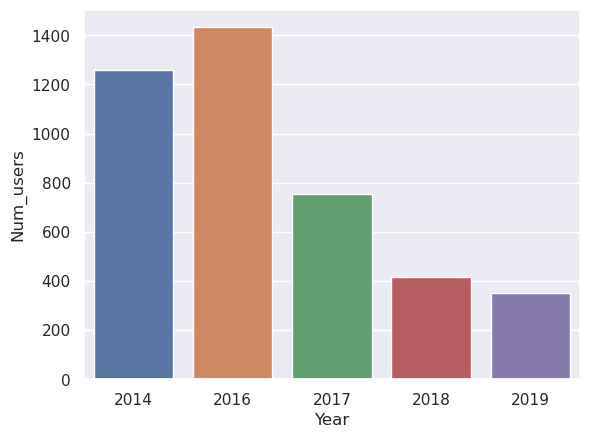

In [89]:
#plot: count of people who took the survery
sns.barplot(x=num_survey['Year'], y= num_survey['Num_users'])
plt.show()

In [90]:
#Number of questions in each survey year
num_que="""
select distinct SurveyID as Year, count(distinct QuestionID) as num_questions
from Answer
group by Year"""
num_que= pd.read_sql(sql=num_que, con=con)
num_que

,Year,num_questions
0,2014,26
1,2016,60
2,2017,76
3,2018,76
4,2019,76


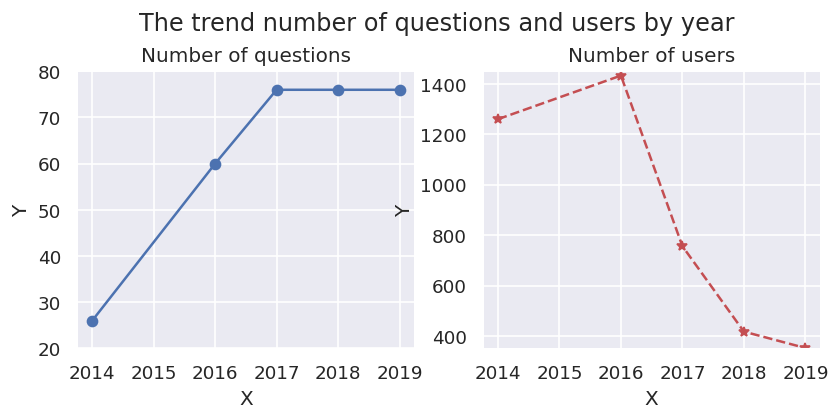

In [91]:
fig, (ax1, ax2)= plt.subplots(1,2,figsize=(8,3), sharex=True, sharey= False, dpi=120)
ax1.plot(num_que['Year'],num_que['num_questions'], 'bo-')
ax2.plot(num_survey['Year'],num_survey['Num_users'],'r*--')
ax1.set(title='Number of questions', xlabel='X', ylabel='Y', ylim=(20,80))
ax2.set(title='Number of users', xlabel='X', ylabel='Y', ylim=(350, 1450))
plt.suptitle('The trend number of questions and users by year',verticalalignment ='bottom')
plt.show()

The number of questions increases each year, it can be a reason why people less join the survey, most of questions are not in scale structure, so it takes a long time to answer all of them. The survey's organization should redesign the questions and the number of them which is easy to attract more volunteers.

In [92]:
#Gender who took the survery analysis
gender_through_years = qa.query("questionid == 2")
gender_through_years.head()

,AnswerText,SurveyID,UserID,questionid,questiontext
1260,Female,2014,1,2,What is your gender?
1261,Male,2014,2,2,What is your gender?
1262,Male,2014,3,2,What is your gender?
1263,Male,2014,4,2,What is your gender?
1264,Male,2014,5,2,What is your gender?


In [93]:


temp_groupby = None
gender_dist = \
{
    "male": [0] * surveys_df.shape[0],
    "female": [0] * surveys_df.shape[0],
    "transgender": [0] * surveys_df.shape[0],
    "non_binary": [0] * surveys_df.shape[0],
    "queer": [0] * surveys_df.shape[0],
    "gender_fluid": [0] * surveys_df.shape[0],
    "other": [0] * surveys_df.shape[0]
}

for idx, year in enumerate(surveys_df["SurveyID"]):
    temp = gender_through_years[gender_through_years["SurveyID"] == year]
    temp_groupby = temp.groupby('AnswerText').count()
    
    for gender, row in temp_groupby.iterrows():
        if "trans" in gender.lower() or "ftm" in gender.lower() or "mtf" in gender.lower():                    
            gender_dist["transgender"][idx] = gender_dist["transgender"][idx] + row[1]
        elif "fluid" in gender.lower():                                                           
            gender_dist["gender_fluid"][idx] = gender_dist["gender_fluid"][idx] + row[1]
        elif "female" in gender.lower() or "she" in gender.lower() or "femina" in gender.lower():                                                           
            gender_dist["female"][idx] = gender_dist["female"][idx] + row[1]
        elif ("non" in gender.lower() and "binary" in gender.lower()) or "nb" in gender.lower():                                                           
            gender_dist["non_binary"][idx] = gender_dist["non_binary"][idx] + row[1]
        elif "queer" in gender.lower():                                                           
            gender_dist["queer"][idx] = gender_dist["queer"][idx] + row[1]
        elif "male" in gender.lower() or "guy" in gender.lower() or "swm" in gender.lower() or "masculino" in gender.lower():                                                           
            gender_dist["male"][idx] = gender_dist["male"][idx] + row[1]
        else:
            gender_dist["other"][idx] = gender_dist["other"][idx] + row[1]



However, bfore we plot the graph, we take a look at the bare numbers that make up the graph.

print(f"Gender distribution: \n")
pprint.pprint(gender_distribution)
print(f"Gender distribution: \n")
pprint.pprint(gender_distribution)
Each row represent the top genders which are manually selected. Inside each row is a list of numbers which corresponds to the total participants of the gender who took the survey the corresponding year (2014, 2016, 2017, 2018, and 2019).


In [94]:
print(f"Gender distribution: \n")
pprint.pprint(gender_dist)

Gender distribution: 

{'female': [248, 340, 219, 128, 100],
 'gender_fluid': [1, 3, 2, 2, 1],
 'male': [996, 1057, 504, 269, 228],
 'non_binary': [2, 8, 8, 5, 4],
 'other': [7, 15, 19, 7, 16],
 'queer': [2, 5, 2, 2, 0],
 'transgender': [4, 5, 2, 4, 3]}


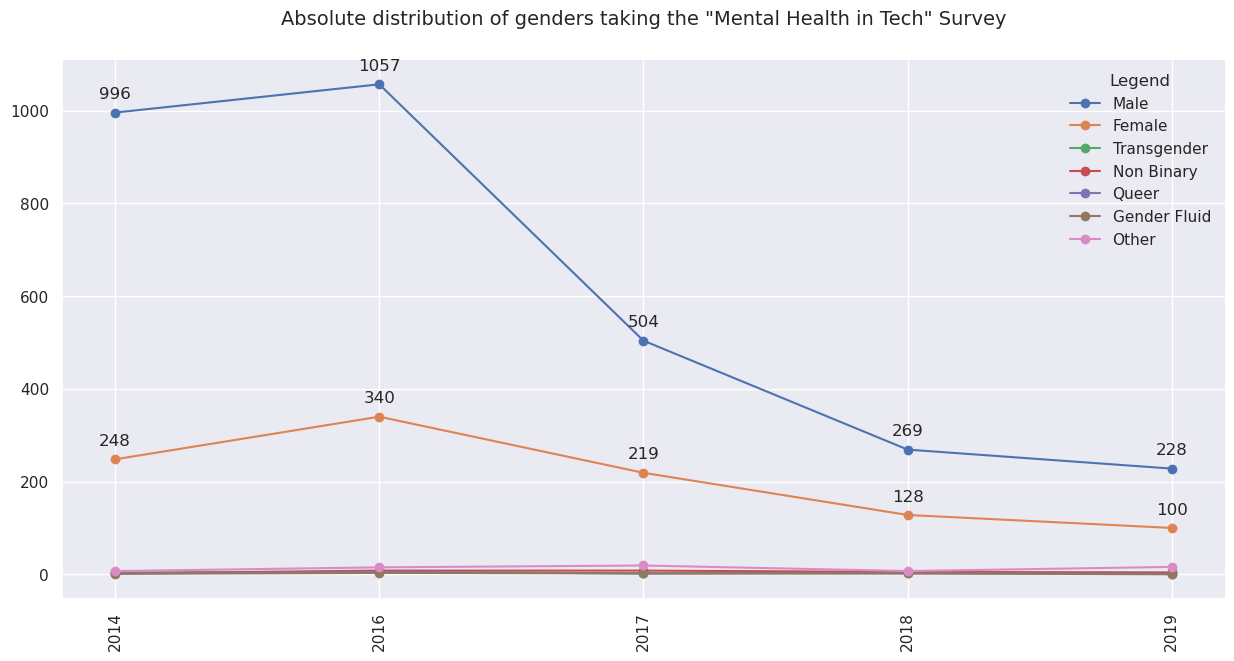

In [95]:
plt.figure(figsize=(15,7))
for key in gender_dist.keys():
    plt.plot(gender_dist.get(key), "o-", label=key.title().replace("_", " "))
    
    if key is "male" or key is "female":                                    
        for x in range(surveys_df.shape[0]):
            plt.annotate(gender_dist.get(key)[x], (x, gender_dist.get(key)[x]),
                         textcoords="offset points",xytext=(0,10), ha='center') 

plt.legend(title="Legend", frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(range(surveys_df.shape[0]), surveys_df['SurveyID'], rotation=90)
plt.title(label="Absolute distribution of genders taking the \"Mental Health in Tech\" Survey",
          fontsize=14,y=1.05)
plt.savefig("./Absolute Gender Distribution.png", dpi=600, transparent=True)
plt.show()

In the graph above we see that the number of total participants has significantly decreased over the years, majority of whom are male. The number of women taking the survey mainly remain constant. Number of people of other genders are very low and it is difficult to establish any pattern as they reamain low throughout the time period.

In [96]:
#que: Average age of developers
pd.read_sql_query(
    "SELECT AVG(AnswerText) FROM question \
     JOIN answer ON question.questionid = answer.QuestionID \
     WHERE question.questiontext = 'What is your age?'" 
    , con)

,AVG(AnswerText)
0,33.915363


Since the dataset is quite large, I will be focusing on the following aspects of the database.

1. Age
2. Gender
3. 57/ 59
4. 9
5. Do you work remotely?
6. What is your race?
7. 33
8. Do you have a family history of mental illness?
9. 

In [97]:
pd.read_sql_query("SELECT AnswerText FROM question JOIN answer ON question.questionid = answer.QuestionID WHERE question.questionID = 5", con)

,AnswerText
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
4213,1
4214,1
4215,1
4216,1


In [98]:
pd.read_sql_query("SELECT DISTINCT(question.questiontext) FROM question JOIN answer ON question.questionid = answer.QuestionID WHERE question.questiontext LIKE '%Describe%'", con)

,questiontext
0,Describe the conversation you had with your em...
1,Describe the conversation with coworkers you h...
2,Describe the conversation your coworker had wi...
3,Describe the conversation you had with your pr...
4,Describe the conversation you had with your pr...
5,Describe the conversation your coworker had wi...
6,Describe the circumstances of the badly handle...
7,Describe the circumstances of the supportive o...
8,Briefly describe what you think the industry a...
9,Which of the following best describes your wor...


At this point, I will be selecting 5 unique questions for further analysis.

Question ID: 1, 2, 3, 20, 6

In [99]:
df = pd.read_sql_query("SELECT question.questiontext AS question, answer.AnswerText AS answer, answer.SurveyID as year, answer.UserID AS user_id, answer.QuestionID AS question_id FROM question JOIN answer ON question.questionid = answer.QuestionID WHERE question.questionid IN (1, 2, 3, 6, 20, 52, 79, 89, 113, 118)", con)
df.head()

,question,answer,year,user_id,question_id
0,What is your age?,-1,2014,391,1
1,What is your age?,-1,2014,716,1
2,What is your age?,-1,2014,1128,1
3,What is your age?,-1,2017,3447,1
4,What is your age?,-1,2017,3449,1


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28704 entries, 0 to 28703
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question     28704 non-null  object
 1   answer       28704 non-null  object
 2   year         28704 non-null  int64 
 3   user_id      28704 non-null  int64 
 4   question_id  28704 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [101]:
df.describe()

,year,user_id,question_id
count,28704.000000,28704.000000,28704.000000
mean,2016.386288,2369.190635,29.640991
std,1.453178,1126.164719,39.162420
min,2014.000000,1.000000,1.000000
25%,2016.000000,1527.750000,2.000000
50%,2016.000000,2424.500000,6.000000
75%,2017.000000,3321.250000,52.000000
max,2019.000000,4218.000000,118.000000


In [102]:
# What is the average age of a developer?

df[df["question_id"]==1]["answer"].astype(int).mean()

33.91536273115221

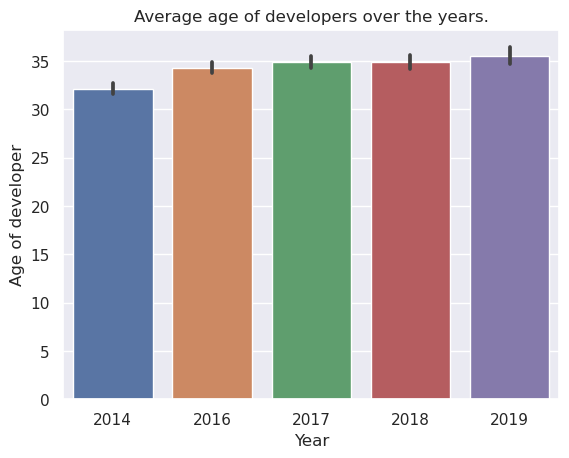

In [103]:
# How has the age of developers progressed over the years?

q1_df = df[df["question_id"]==1]

q1_df["answer"] = q1_df["answer"].astype(int)

sns.barplot(x="year", y="answer", data=q1_df)
plt.title("Average age of developers over the years.")
plt.xlabel("Year")
plt.ylabel("Age of developer")
plt.show()

Let's look at gender distribution. First, let's see all unique answers to see if we can categorize them. Just for fun let's do it with sql query. SELECT DISTINCT AnswerText FROM answer Where QuestionID = 2

In [106]:
#gender distribution in united states
genderAnswers= pd.read_sql_query('SELECT DISTINCT (a.AnswerText) FROM answer a JOIN answer b ON b.UserID = a.UserID WHERE b.AnswerText = "Male" AND b.AnswerText = "United States" OR b.AnswerText = "United States of America" AND a.QuestionID = 2'
,con)
genderAnswers.head()


,AnswerText
0,Male
1,Female
2,fm
3,Female or Multi-Gender Femme
4,Other


Unfortunately, when it comes to responses we are seeing examples like "God King of the Valajar" or "I have a penis" or "I am a Wookie". This makes it very difficult to inner-categorize LGBTQ community. The only way to do that is to go manually through each non-male/female response. Moreover, I don't have extensive knowledge of LGBTQ community, thus I can't make accurate groupings. I hate to be exclusive, but we will have to unite all nontrivial answers as one LGBTQ group. 

In [105]:
genderUSA = dfUSA[dfUSA['QuestionID']==2]
genderUSA.AnswerText.value_counts()

NameError: name 'dfUSA' is not defined

We can see that significant amount of records contain female and male records with lovercase, let's fix it

In [ ]:
genderUSA.loc[genderUSA['AnswerText'] == 'male', 'AnswerText'] = 'Male'
genderUSA.loc[genderUSA['AnswerText'] == 'female', 'AnswerText'] = 'Female'

In [ ]:
genderUSA['AnswerText'] = np.where((genderUSA['AnswerText'] == 'Male') | (genderUSA['AnswerText'] == "Female"),
                                   genderUSA['AnswerText'], 'Other')

Now for the graph let's add iteration column that will server as number of rows for our graph.

In [ ]:
genderUSA = genderUSA.assign(iteration= lambda x: 1)
fig = px.pie(genderUSA, values = 'iteration', names = 'AnswerText')
fig.show()

In [ ]:
q2_df = df[df["question_id"]==2]
q2_df["answer"] = q2_df["answer"].str.lower()
q2_df["mapped_gender"] = np.where(q2_df["answer"] == "male", "Male", np.where(q2_df["answer"] == "female", "Female", "Others"))
q2_df["mapped_gender"].value_counts()

A quick glance at this graph could tell us that Males are overrepresented in this survey, however, distribution of genders is pretty close to the gender representation reported by dataprot.net 

In [ ]:
diagnosed = dfUSA.loc[dfUSA['QuestionID']==34]
diagnosed = diagnosed.assign(iteration= lambda x: 1)
diagnosed.AnswerText.unique()



We can see that some records contain '-1'. It means people refused/didn't answer this question

Let's remove them from the dataframe


In [ ]:
# diagnosed = diagnosed[diagnosed['AnswerText'] != '-1']

In [ ]:
#let's plot the graph
fig = px.pie(diagnosed, values = 'iteration', names = 'AnswerText')
fig.show()

We can see that almost 3/4 of people who participated in the survey were diagnosed with mental ilness. It's much higher than National average of almost 20% reported by NIH. Of course, we could assume that working in Tech is more stressful than in many other fields. However, I think this difference is explained by a basic bias of participation. More people who had this problem or who knows someone who had this problem will take their time and participate in the survey while people who never had mental ilness problem will be less likely to participate. Especially given that this question came 34-th, which takes much more time to answer than let's say a typical Presidential Voting Poll.

Let's see how many people sought at some point treatment for Mental Disorder

In [ ]:
sought = dfUSA.loc[dfUSA['QuestionID']==7]
sought = sought.assign(iteration= lambda x: 1)
sought.AnswerText.unique()

In [ ]:
#let's change boolean value to yes or no
sought.loc[sought['AnswerText'] == '0', 'AnswerText'] = 'No'
sought.loc[sought['AnswerText'] == '1', 'AnswerText'] = 'Yes'

In [ ]:
fig = px.pie(sought, values = 'iteration', names = 'AnswerText')
fig.show()

We can see that 63.3% sought treatment for a mental health disorder, compared to 36.7% who didn't. But hold on, we had 72.1% diagnosed with Mental Discorder, why did only 63.3% sought treatment? We have a sample of around 2600 here, while we had a sample of less than 1400 in the previous graph. It comes to bias again, more people to whom this problem isn't as important came through the 7-th question compared to 34-th. Thus, we can't make a claim that there are more people who were diagnosed with mental disorder than those who sought help as there are significantly more people who answered one question over the other. What we can do is to see if people tend to seek streatment more often if their current or previous employer provided respective benefits.

In [ ]:
currentEmployer = dfUSA.loc[dfUSA['QuestionID']==10]
previousEmployer = dfUSA.loc[dfUSA['QuestionID']==23]

In [ ]:
currentEmployer.AnswerText.unique()

In [ ]:
previousEmployer.AnswerText.value_counts()

In [ ]:
#country of developers
q3_df = df[df["question_id"]==3]
# q3_df.unique()
q3_df.head()

In [ ]:
q3_df["answer"].describe()

There are 4,218 answers for the question, "What country do you live in?". Among these entries, there are 81 unique entries of which the most occuring answer is the United States of America.

For the first part, I want to focus on participants who live in the US. We can see there are 2 variations of how the US is recorded: 'United States' and 'United States of America' We will create a new dataframe that will only have participants from the US. Later we can always come back to original df if we want to explore anything else.

A simple self join get the job done. In this case we also include immigrants who worked in the US as we also go through the question #50 SELECT a.* FROM answer a JOIN answer b ON b.UserID = a.UserID WHERE b.AnswerText = "United States" OR b.AnswerText = "United States of America" Order by a.UserID

In [ ]:
dfUSA = pd.read_sql_query('SELECT DISTINCT a.* FROM answer a JOIN answer b ON b.UserID = a.UserID WHERE b.AnswerText = "United States" OR b.AnswerText = "United States of America"'
,con)
dfUSA.head(10)

In [ ]:
#family history of mental illness
q6_df = df[df["question_id"]==6]
q6_df.head()

In [ ]:
q6_df["answer"].value_counts()

In [ ]:
sns.countplot(x="answer", data=q6_df)
plt.title("How many developers have a family history of mental illness?")
plt.xlabel("Response")
plt.show()

In [ ]:
#medical coverage
q20_df = df[df["question_id"]==20]
q20_df.head()

In [ ]:
q20_df["answer"].value_counts()
st = q20_df.iloc[5, 0]
st

In [ ]:
sns.countplot(x="answer", data=q20_df)
plt.title("Plot showing how many developers have medical coverage")
plt.xlabel("Response")
plt.ylabel("Count")
plt.show()

In [ ]:
#country and data
country_df = qa.query("questionid == 3")[["SurveyID", "AnswerText"]]

country_dict = {}

for year in surveys_df['SurveyID']:
    year_country_df = country_df[(country_df.SurveyID == year)]
    value_counts = year_country_df.value_counts()
    temp_dict = {}
    
    for country_name, country_no in zip(value_counts.index, value_counts):
        country_name = country_name[1]  
        
        if country_name == "United States" or  country_name == "United States of America":
            temp_dict["USA"] = int(country_no)

        else:
            temp_dict[country_name] = int(country_no)
    
    country_dict[year] = temp_dict

country_df = pd.DataFrame(country_dict)
country_df.to_csv("./Countries taking the survey.csv", index=False)
display(country_df)

Since plotiing so many country data on a plot will virtually make the graph unreadable, we decided to plot the top 5 countries for each year. The below graphs display the same.

On hovering over the graph we get a pop-up of the country and the number of people taking part from that country in that year.

In [ ]:
for column in country_df.columns:
    count_df = country_df[column].sort_values(ascending=False).head(5)
    count_df_others_sum = count_df[6:].sum()
    temp_df = count_df.head(5)
    temp_df.loc["Others"] = count_df_others_sum
    
    fig = px.pie(temp_df,
            values=column, 
            names=temp_df.index,
            title="Top 5 countries taking the survey "+str(column),
            labels={
                "index":"Country"
            })
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.update_layout(template="plotly_dark")
    fig.show()